# Cogs 118b Final Project
### PCA and KMeans on S&P 500 data to cluster and visualize stocks in order to organize a diverse portfolio

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import linalg as la
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker
from textwrap import fill
import time

# Scrap data


In [2]:
#reads s&p5j00 symbols from https://github.com/datasets/s-and-p-500-companies/blob/master/data/constituents.csv and gets Beta,Weighted Alpha,ROE%,Market Cap,Price Earnings ttm,Earnings Per Share ttm,'ROA% from barchart 
import requests as req
from bs4 import BeautifulSoup
from urllib.parse import unquote
import json

scrap_data = False

if scrap_data == True:
  sp500 = pd.read_csv('SP500.csv')
  df = pd.DataFrame(columns = ['Symbol','Name','Sector','Beta','Weighted Alpha','ROE%','Market Cap','Price Earnings ttm','Earnings Per Share ttm','ROA%'])
  
  getheaders = {
      'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
      'accept-encoding': 'gzip, deflate, br',
      'accept-language': 'en-US,en;q=0.9',
      'cache-control': 'max-age=0',
      'upgrade-insecure-requests': '1',
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36'
      }
  
  getpay = {
      'page': 'all'
  }
  s=req.Session()

  for i, r in sp500.iterrows():
      URL = 'https://www.barchart.com/stocks/quotes/'+r['Symbol']+'/overview?page=all'
      URLTWO = 'https://www.barchart.com/stocks/quotes/'+r['Symbol']+'/profile'

      page = s.get(URL, params = getpay, headers = getheaders)
      pageTwo = s.get(URLTWO, params = getpay, headers = getheaders)
      df_list = pd.read_html(pageTwo.text)
      beta = df_list[0].iloc[6, 1]
      marketcap = df_list[0].iloc[0, 1]
      eps = df_list[2].iloc[2, 1]
      pe = df_list[3].iloc[0, 1]
      roe = df_list[3].iloc[3, 1]
      roa = df_list[3].iloc[4, 1]
      soup = BeautifulSoup(page.content, "html.parser")
      data = soup.find('div', {'class': 'bc-quote-overview row'})['data-ng-init']
      data = data[data.find('{'):data.rfind('}')+1]
      data1 = data[data.find('{'):data.find('},')+1]
      data = data[data.find('},')+2:]
      data2 = data[data.find('{'):data.find('},')+1]
      data3 = data[data.find('},')+2:]
      json_object = json.loads(data3)
      weightedAlpha = json_object['raw']['weightedAlpha']
      df = df.append({'Symbol':r['Symbol'],'Name':r['Name'],'Sector':r['Sector'],'Beta':beta,'Weighted Alpha':weightedAlpha,'ROE%':roe,'Market Cap':marketcap,'Price Earnings ttm':pe,'Earnings Per Share ttm':eps,'ROA%':roa},ignore_index=True)
      df.to_csv('data/sp500stuff.csv')


In [3]:
#read s&p 500 data
test_universe = pd.read_csv('data/sp500stuff.csv')

#drop all rows that contain nan
test_universe = test_universe.dropna()

#drop first column which contains the number of entries
test_universe = test_universe.iloc[: , 1:]

#strip % and convert to float
test_universe['ROE%'] = test_universe['ROE%'].str.rstrip('%').astype(float)
test_universe['ROA%'] = test_universe['ROA%'].str.rstrip('%').astype(float)
test_universe.head()
nameArr=test_universe['Name'].tolist()
symblArr=test_universe['Symbol'].tolist()
sectrArr=test_universe['Sector'].tolist()

In [4]:
#get only columns with continuous variables
data = test_universe[["Beta", "Weighted Alpha", "ROE%", "Market Cap"]]
data.head()

,Beta,Weighted Alpha,ROE%,Market Cap
0,0.97,-26.9,40.84,83723264
1,1.20,-1.5,26.35,10772085
2,0.76,-2.4,27.06,208778640
3,0.80,44.1,164.05,263261344
4,1.24,6.1,30.42,195600800


In [5]:
#Scale data using standard scalar because they all have very different ranges
test_universe_scaled = StandardScaler().fit_transform(data.values)
test_universe_scaled = pd.DataFrame(test_universe_scaled, index=data.index, columns=data.columns)

test_universe_scaled.head()

,Beta,Weighted Alpha,ROE%,Market Cap
0,-0.302472,-1.034050,0.015351,0.035074
1,0.154015,-0.210218,-0.045229,-0.311826
2,-0.719264,-0.239409,-0.042260,0.629742
3,-0.639875,1.268787,0.530466,0.888820
4,0.233404,0.036283,-0.028213,0.567078


# PCA
### Use PCA to reduce dimensions 

In [6]:
test_universe_scaled = np.asarray(test_universe_scaled)

mean = np.mean(test_universe_scaled, axis = 1, keepdims = True)

A = test_universe_scaled - mean

cov = A @ A.T

Lambda_old, v_old = la.eig(cov)

In [7]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(Lambda_old[i]), v_old[:, i]) for i in range(len(Lambda_old))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [8]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

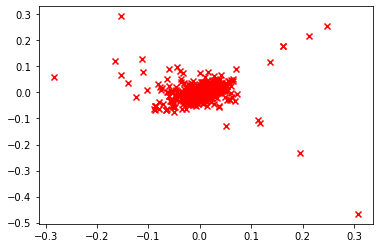

In [9]:
plt.scatter(np.real(W[:, 0]), np.real(W[:, 1]), marker = 'x', color = "red");

# KMeans to cluster and visualize
#### Idea: then able to pick a diverse portfolio from clusters or check if current portfolio is diverse by these attributes

In [10]:
def calcSqDistances(X, Kmus):

  sqDmat = ((-2*X.dot(Kmus.T)+np.sum(np.multiply(Kmus, Kmus), axis = 1).T).T + np.sum(np.multiply(X,X), axis = 1)).T
  
  return sqDmat

In [11]:
def determineRnk(sqDmat):

  m = np.argmin(sqDmat, axis = 1)
  
  return np.eye(sqDmat.shape[1])[m]

In [12]:
def recalcMus(X, Rnk):
  
  return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis = 0))).T

In [13]:
#plotCurrent (np.float64 numpy array:X=array,np.float64 numpy array:Rnk=array,np.float64 numpy array:Kmus=array,bool:dfOnly={True,False},string:ret={'wcss','dataframe','none'},string:legLabels={'symbol','name','sector','none'},bool:pltSubClusters={True,False})
def plotCurrent(X, Rnk, Kmus, dfOnly,legLabels,pltSubClusters):
    N, D = X.shape
    K = Kmus.shape[0]
    InitColorMat = cm.gist_rainbow(np.linspace(0, 1, len(np.arange(K))))
    KColorMat = InitColorMat[0:K,:]
    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    colorTup = tuple(map(tuple,colorVec.tolist()))
    df = pd.DataFrame({'color':colorTup, 'symbol':symblArr, 'name':nameArr, 'sector':sectrArr, 'x':np.real(X[:,0]),'y':np.real(X[:,1])})


    if (legLabels == 'name'):
      dfg = df.groupby(['color'])['name'].apply(lambda x: ', '.join(x)).reset_index()

    elif (legLabels == 'sector'):
      dfg=df.groupby(['color','sector']).size().to_frame('count').reset_index()
      df_colorSize = df.groupby(['color']).size().to_frame('size').reset_index()
      dfge = pd.DataFrame(columns = dfg['color'].unique())
      num = 0

      for index, row in dfg.iterrows():
        num = df_colorSize['size'].loc[df_colorSize['color'] == row['color']].tolist()[0]
        dfge = dfge.append({row['color']:str(row['sector']+': '+str(row['count'])+'/'+str(num)+' = '+'{:.2f}'.format((row['count']/num)*100)+'%')},ignore_index = True)


    dfg = df.groupby(['color'])['symbol'].apply(lambda x: ', '.join(x)).reset_index()

    if(not(dfOnly)):
      plt.rcParams["figure.figsize"] = (10,10)
      patch=[]

      if(legLabels == 'name' or legLabels == 'symbol'):

        for i,row in dfg.iterrows():

          if(legLabels == 'name'):
            patch.append(mpatches.Patch(color=np.asarray(row['color']), label = str(i+1)+': ['+fill(row['name'],width=100)+']'))
          else:
            patch.append(mpatches.Patch(color=np.asarray(row['color']), label = str(i+1)+': ['+fill(row['symbol'],width=100)+']'))
      else:
        i = 0

        for col in dfge.columns:
          temp = ', '.join(dfge[col].dropna().tolist())
          patch.append(mpatches.Patch(color = np.asarray(col), label = str(i+1)+': ['+fill(temp,width=100)+']'))
          i+=1
          
      if(pltSubClusters):
        plt.rcParams["figure.figsize"] = (10,10)
        df_s = df.sort_values('color')
        tempTwo = df_s['color'].iloc[0]
        subCount = 1

        for i,row in df_s.iterrows():
          
          if(row['color'] == tempTwo):
            plt.scatter(row['x'], row['y'], color=row['color'])
            plt.annotate(row['symbol'],(row['x'], row['y']))
          else:
            plt.axis('equal')
            plt.title('KMeans subPlot cluster: '+str(subCount))
            print(subCount)
            plt.show()
            subCount+=1
            tempTwo=row['color']
            plt.scatter(row['x'], row['y'], color=row['color'])
            plt.annotate(row['symbol'],(row['x'], row['y']))
        plt.scatter(row['x'], row['y'], color=row['color'])
        plt.annotate(row['symbol'],(row['x'], row['y']))
        plt.axis('equal')
        plt.title('KMeans subPlot cluster: '+str(subCount))
        plt.show()
      else:
        plt.scatter(np.real(X[:,0]), np.real(X[:,1]), c=colorVec)
        plt.scatter(np.real(Kmus[:,0]), np.real(Kmus[:,1]), s = 200, c=muColorVec, marker='d')
        plt.axis('equal')
        plt.title('KMeans Plot')
        plt.legend(handles=patch,loc = 'right',bbox_to_anchor=(-0.1, 0.5),prop={'size': 16})
        plt.show()
      plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    else:
      return df

In [14]:
#runKMeans takes parameters 
#runKMeans(int:K=#of clusters,2d np.float64 numpy array:data=array,string:displayPlot={'step','final','none'},string:ret={'wcss','dataframe','none'},string:legLabels={'symbol','name','sector','none'},bool:pltSubClusters={True,False})

def runKMeans(K,data,displayPlot,ret,legLabels,pltSubClusters):
    #determine and store data set information
    X = data
    N = np.shape(X)[0]
    D = np.shape(X)[1]

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    # Set a seed so plots will be consistent everytime it is ran
    randSeed = 67
    rndinds = np.random.RandomState(seed=randSeed).permutation(N)

    Kmus = X[rndinds[:K]]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        if(displayPlot=='step'):
           plotCurrent(X, Rnk, Kmus,False,legLabels,pltSubClusters)
           time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            break
    if(displayPlot=='final'or displayPlot=='step'):
      plotCurrent(X, Rnk, Kmus, False, legLabels, pltSubClusters)
    if(ret=='dataframe'):
      df=plotCurrent(X, Rnk, Kmus, True, legLabels, pltSubClusters)
      return df
    elif(ret=='wcss'):
      #wcss
      return np.multiply(np.real(Rnk).flatten(),np.real(sqDmat).flatten()).sum()

In [15]:
#looking online and saw using elbow method to determine optimal K ---- so maybe try that?

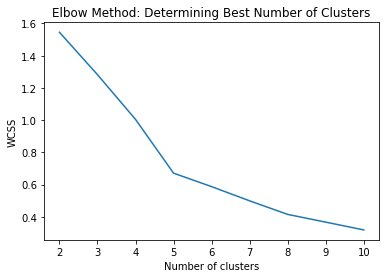

In [16]:
#run kmeans for cluster size of 2-10 and use the returned wcss to plot a wcss vs number of cluster chart
count = 0
arr = np.zeros(9)
for i in range(2,11):
  arr[count] = runKMeans(i, W, 'none','wcss','none',False)
  count+= 1
plt.plot(range(2, 11), arr)
plt.title('Elbow Method: Determining Best Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

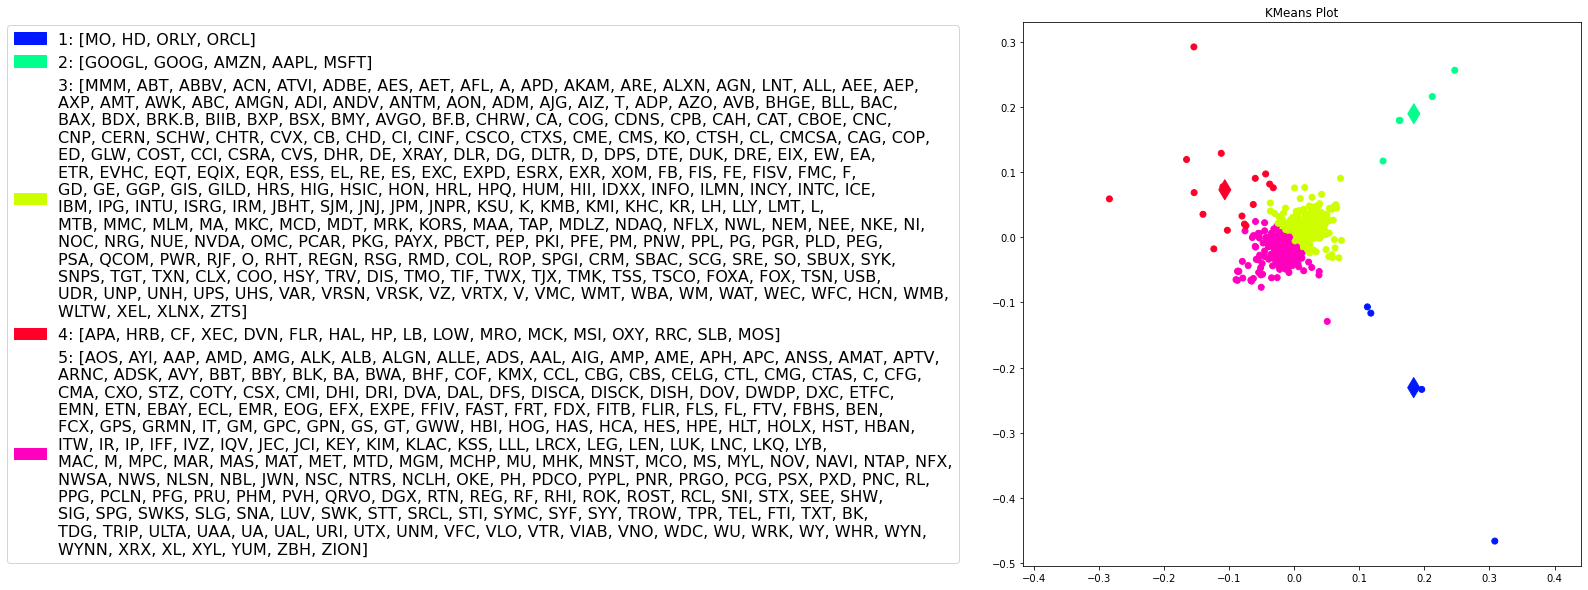

In [17]:
#plot kmeans for 5 clusters with legends defining which symbols each cluster contains. 
runKMeans(5, W, 'final', 'none', 'symbol', False)

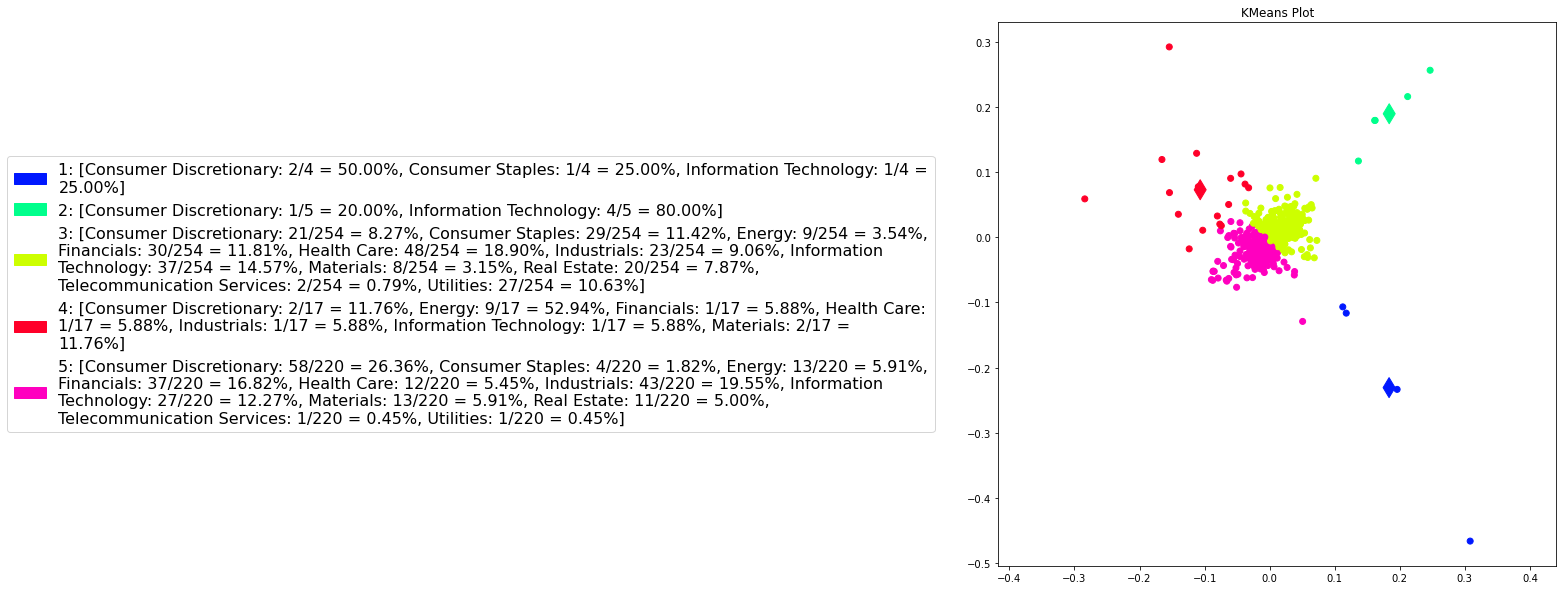

In [18]:
#plot kmeans for 5 clusters with legends defining which sector each cluster contains. 
runKMeans(5, W, 'final', 'none', 'sector', False)

1


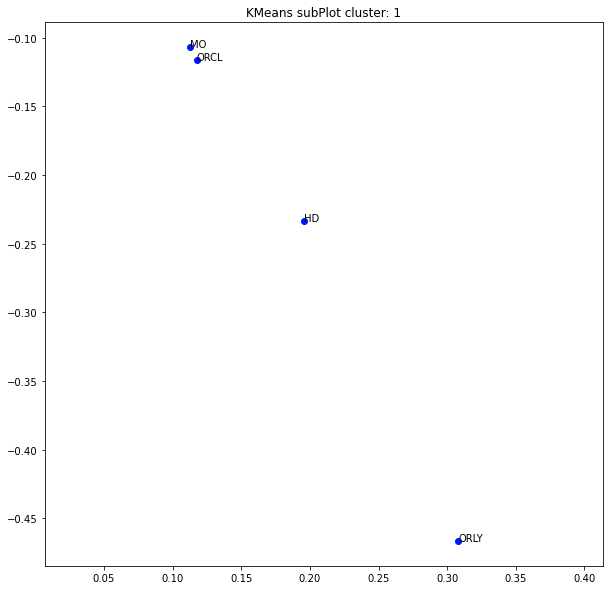

2


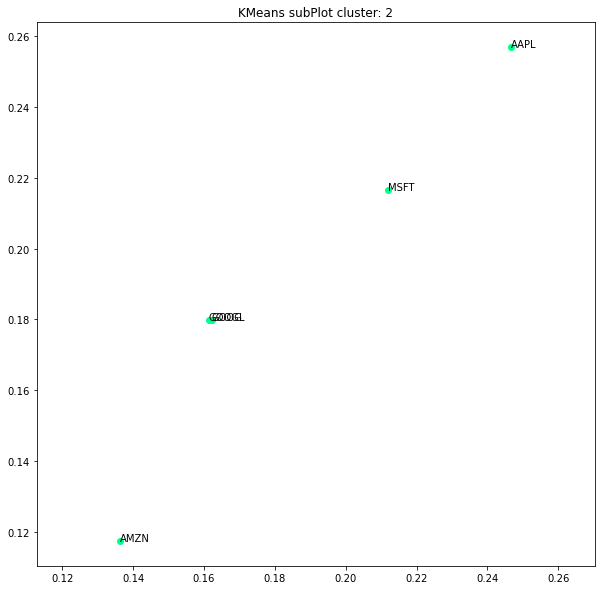

3


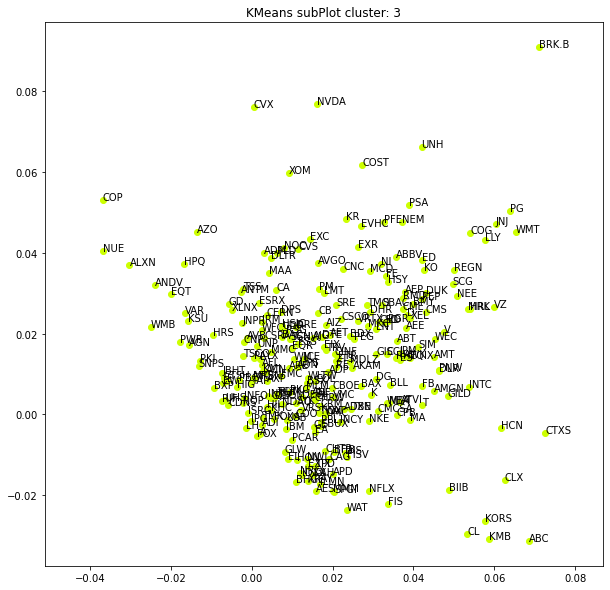

4


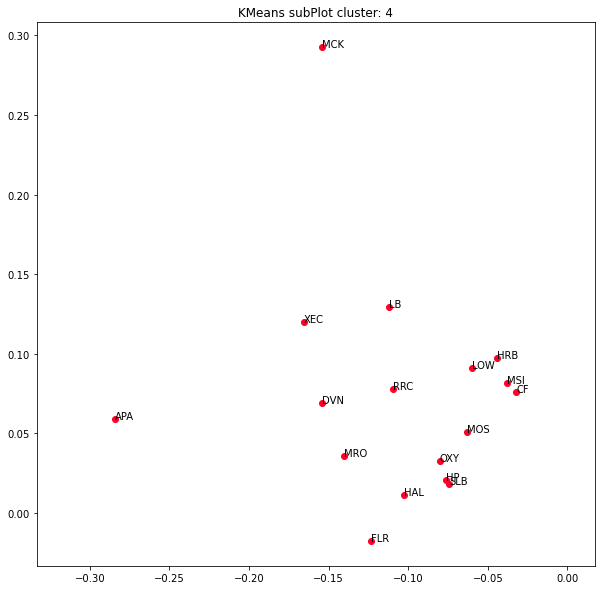

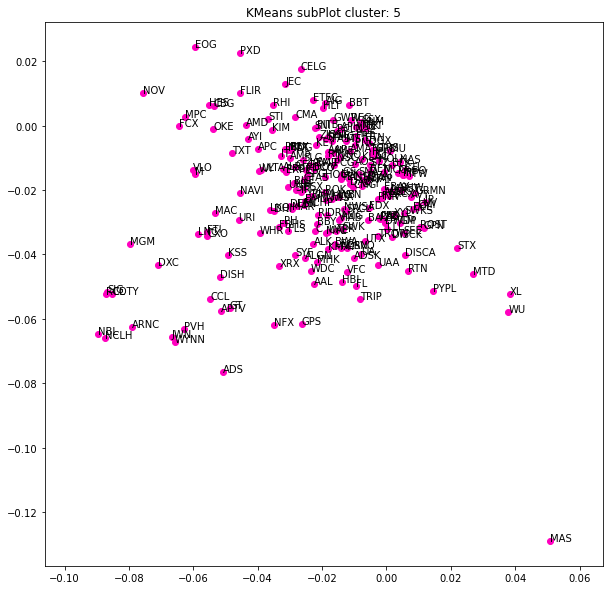

In [19]:
#plot separate kmeans for the 5 clusters
runKMeans(5, W, 'final', 'none', 'symbol', True)

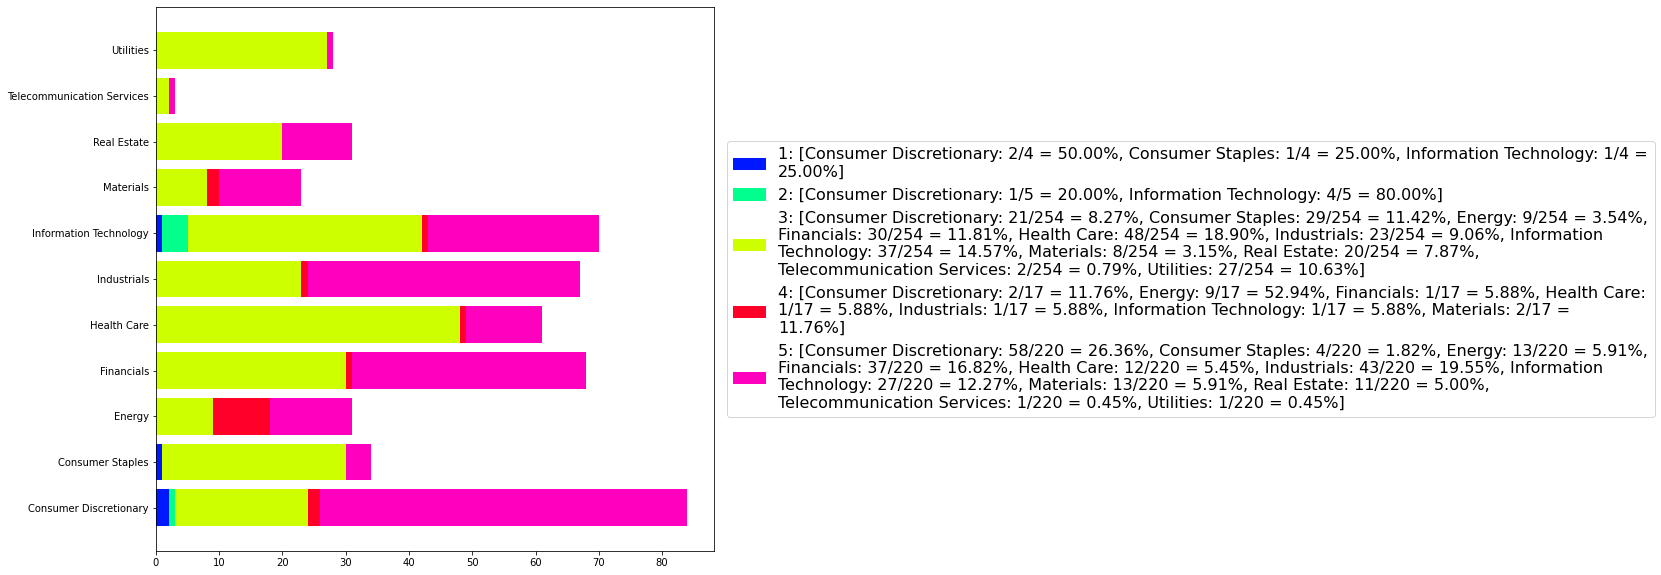

In [20]:
#create stack bargraph and sector legend
df=runKMeans(5, W, 'none', 'dataframe','sector',False)
dfg=df.groupby(['color','sector']).size().to_frame('count').reset_index()
df.drop(columns=df.columns.difference(['color','sector']), axis=1, inplace=True)
df.sort_values(by=['sector'])
lbl=df['sector'].unique()
gb = df.groupby('color') 
a=[gb.get_group(x) for x in gb.groups]   

for i,dfi in enumerate(a):
  a[i]=a[i].groupby(['color','sector']).size().to_frame('count').reset_index()
  for j in lbl:
    if(not (j in a[i].values)):
      a[i]=a[i].append({'color':dfi['color'].iloc[0],'sector':j,'count':0},ignore_index=True)
  a[i]=a[i].sort_values(by=['sector']).reset_index()
lbl=a[0]['sector']
plt.rcParams["figure.figsize"] = (10,10)
for i,dfi in enumerate(a):
  if(i==0):
    temp=a[i]['count']
    plt.barh(lbl,a[i]['count'], color = a[i]['color'].iloc[0])
  else:
    plt.barh(lbl,a[i]['count'], color = a[i]['color'].iloc[0], left=temp)
    temp+=a[i]['count']
df_colorSize=df.groupby(['color']).size().to_frame('size').reset_index()
dfge=pd.DataFrame(columns=dfg['color'].unique())
num=0
for index, row in dfg.iterrows():
  num=df_colorSize['size'].loc[df_colorSize['color'] == row['color']].tolist()[0]
  dfge=dfge.append({row['color']:str(row['sector']+': '+str(row['count'])+'/'+str(num)+' = '+'{:.2f}'.format((row['count']/num)*100)+'%')},ignore_index=True)
i=0
patch=[]
for col in dfge.columns:
  temp=', '.join(dfge[col].dropna().tolist())
  patch.append(mpatches.Patch(color=np.asarray(col), label=str(i+1)+': ['+fill(temp,width=100)+']'))
  i+=1
plt.legend(handles=patch,loc='right',bbox_to_anchor=(2.7, 0.5),prop={'size': 16})
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

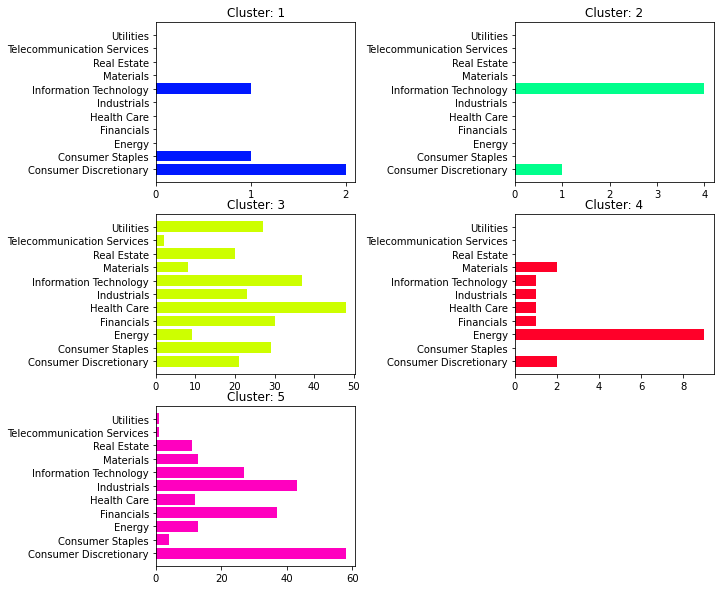

In [21]:
#create bar graph for each of the 5 clusters
df = runKMeans(5, W, 'none', 'dataframe','sector',False)
df.drop(columns=df.columns.difference(['color','sector']), axis=1, inplace=True)
df.sort_values(by=['sector'])
lbl = df['sector'].unique()
gb = df.groupby('color') 
a = [gb.get_group(x) for x in gb.groups]
for i,dfi in enumerate(a):
  a[i]=a[i].groupby(['color','sector']).size().to_frame('count').reset_index()
  for j in lbl:
    if(not (j in a[i].values)):
      a[i]=a[i].append({'color':dfi['color'].iloc[0],'sector':j,'count':0},ignore_index=True)
  a[i]=a[i].sort_values(by=['sector']).reset_index()
lbl = a[0]['sector']
plt.rcParams["figure.figsize"] = (10,10)
f, ax = plt.subplots(nrows = 3, ncols = 2)
f.delaxes(ax[2,1]) 
ax[0,0].barh(lbl,a[0]['count'], color = a[0]['color'].iloc[0])
ax[0,0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax[0,0].title.set_text('Cluster: ' + str(1))
ax[0,1].barh(lbl,a[1]['count'], color = a[1]['color'].iloc[0])
ax[0,1].title.set_text('Cluster: ' + str(2))
ax[1,0].barh(lbl,a[2]['count'], color = a[2]['color'].iloc[0])
ax[1,0].title.set_text('Cluster: ' + str(3))
ax[1,1].barh(lbl,a[3]['count'], color = a[3]['color'].iloc[0])
ax[1,1].title.set_text('Cluster: ' + str(4))
ax[2,0].barh(lbl,a[4]['count'], color = a[4]['color'].iloc[0])
ax[2,0].title.set_text('Cluster: ' + str(5))
plt.subplots_adjust(wspace=0.8)
plt.show();

In [22]:
def clusters(df):

   num = df['color'].nunique()

   lists = [pd.DataFrame() for i in range(num)]

   count = 0

   for cluster in df['color'].unique():
     lists[count] = df.loc[df['color'] == cluster]
     lists[count].columns = ['Color','Symbol', 'Sector']
     lists[count] = pd.merge(lists[count], test_universe, on = ('Symbol', 'Sector'))
     count += 1

   return lists

df = runKMeans(5, W, 'none', 'dataframe','sector', False)
df = df.drop('x', axis = 1)
df = df.drop('y', axis = 1)
df = df.drop('name', axis = 1)

clusters = clusters(df)

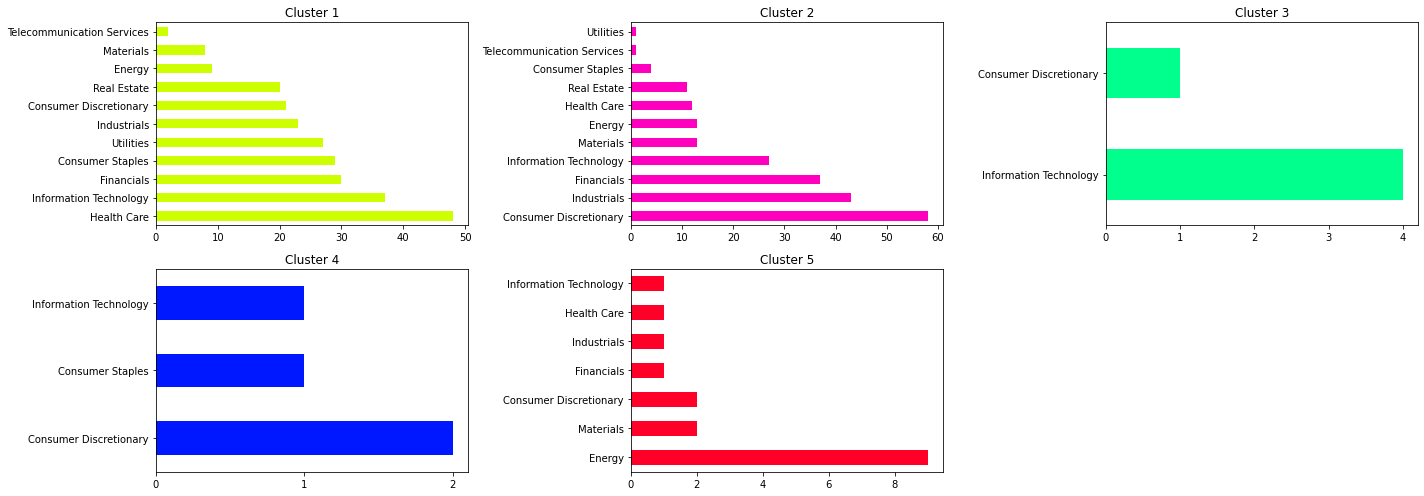

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(20, 7))

clusters[0]['Sector'].value_counts().plot(ax=axes[0,0], kind = 'barh', color = clusters[0]['Color'][0], title = 'Cluster 1')
clusters[1]['Sector'].value_counts().plot(ax=axes[0,1], kind = 'barh', color = clusters[1]['Color'][0], title = 'Cluster 2')
clusters[2]['Sector'].value_counts().plot(ax=axes[0,2], kind = 'barh', color = clusters[2]['Color'][0], title = 'Cluster 3')
clusters[3]['Sector'].value_counts().plot(ax=axes[1,0], kind = 'barh', color = clusters[3]['Color'][0], title = 'Cluster 4')
clusters[4]['Sector'].value_counts().plot(ax=axes[1,1], kind = 'barh', color = clusters[4]['Color'][0], title = 'Cluster 5')
axes[0,2].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axes[1,0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
fig.tight_layout()
fig.delaxes(axes[1][2])